Gievn the different gemotry, the goal is to test and to realize how CNN works
The setting is simple, the geometry dataset is in same color, side_lenth ,and without roation



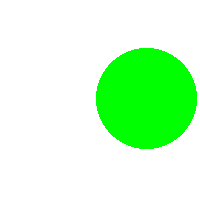
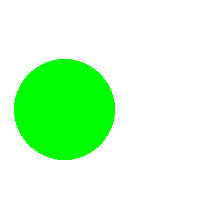


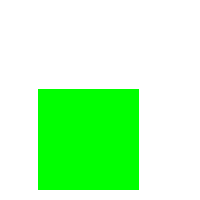
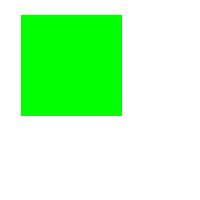


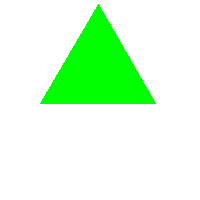
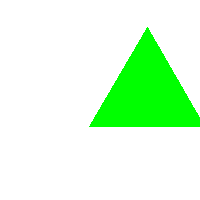

In [1]:
from PIL import Image, ImageDraw
from libs.geometry import *
from libs.utilty import *

def generate_shape_image(width, height, num_each_shape, shape_type, save_path, color_type='random',side_length_type='random',rotation_bool=True):

    #label_dict={}
    for i in range(num_each_shape):
        # Create a blank white image
        image = Image.new("RGB", (width, height), "white")

        draw = ImageDraw.Draw(image)        
        # determine color
        color=determine_color(color_type)
        # determine square or circle
        draw=determine_radius_perserving_gemotry(draw, height, width, shape_type, color, side_length_type, rotation_bool)
        # determine triangle
        draw=determine_triangle(draw, height, width, shape_type, color, side_length_type, rotation_bool)

        image_save(image,i,save_path,shape_type)


if __name__ == "__main__":
    width=200
    hight=200
    num_each_shape=100
    for shape_type in ['circle','square','triangle']:
        generate_shape_image(width, hight, 
                            num_each_shape, 
                            shape_type,
                            "./pic/",
                            color_type='fix', #random or fix
                            side_length_type='fix', #whether fix the side_length of geometry
                            rotation_bool=False) #whether fix the roation
        
    print('Gievn the different gemotry, the goal is to test and to realize how CNN works')
    print('The setting is simple, the geometry dataset is in same color, side_lenth ,and without roation')

    display_side_by_side(['./pic/circle/0.png','./pic/circle/1.png'])
    display_side_by_side(['./pic/square/0.png','./pic/square/1.png'])
    display_side_by_side(['./pic/triangle/0.png','./pic/triangle/1.png'])

In [2]:
from torch.utils.data import DataLoader,random_split
from torchvision.transforms import transforms
from torchvision import transforms, datasets

print('def data_loader')
def exp_data_loader(image_height, image_width, batch_size):
    data_transform = transforms.Compose([
        transforms.Resize((image_height, image_width)),  # resize the image
        transforms.ToTensor(),         # to tensor datatype
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalization
    ])

    dataset = datasets.ImageFolder(root='./pic', transform=data_transform)
    dataset_size = len(dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Create datasets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders for each subset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


def data_loader


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pickle
print('def the NetWork and training_process')

class SimpleCNN(nn.Module):
    def __init__(self, image_height, image_width, number_classes):
        super(SimpleCNN, self).__init__()
        #batch_size
        fc_input_size = 32 * (image_height // 4) * (image_width // 4)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, number_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.squeeze()
        fc_input_size = 32 * (x.size(2)) * (x.size(3))
        x = x.view(-1, fc_input_size)

        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
def validate_model(model, criterion, val_loader, device):
    model.eval()  
    val_loss = torch.tensor(0.0)
    correct = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())    

    val_loss /= len(val_loader.dataset)
    accuracenter_y = correct / len(val_loader.dataset) * 100

    cm = confusion_matrix(true_labels, predicted_labels)
    return val_loss, accuracenter_y, cm    

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, checkpoint_interval, device, result_save_name):
    os.makedirs('checkpoints', exist_ok=True)
    epoch_list=[]
    training_loss_list=[]
    validation_loss_list=[]
    val_acc_list=[]
    cm_list=[]
    for epoch in range(num_epochs):
        epoch_list.append(epoch)
        model.train()  
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        training_loss_list.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Validate the model
        if (epoch + 1) % checkpoint_interval == 0:

            val_loss, val_acc, confusion_matrix = validate_model(model, criterion, val_loader, device)
            print(f"Validation Loss: {val_loss:.4f}, Accuracenter_y: {val_acc:.2f}%")
            print(f'confusion_matrix:\n {confusion_matrix}')
            # Save model checkpoint
            checkpoint_path = f"checkpoints/{result_save_name}_model_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")
            validation_loss_list.append(val_loss.cpu().numpy())
            val_acc_list.append(val_acc)
            cm_list.append(confusion_matrix)
    result_dict={'epoch_list':epoch_list,
                 'training_loss_list':training_loss_list,
                 'validation_loss_list':validation_loss_list,
                 'val_acc_list':val_acc_list,
                 'cm_list':cm_list
                 }
    with open('./checkpoints/'+result_save_name+'.pkl', 'wb') as f:
        pickle.dump(result_dict, f)
    return result_dict

def the NetWork and training_process


In [4]:
###training_process
print('dataloader and training_process')


image_height =200  # 假设输入图片大小为200x200
image_width= 200
batch_size=64
num_epochs = 10
checkpoint_interval = 2
result_save_name='simple_dataset'

def training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    folder_path='./pic'
    number_classes=len([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))])

    model = SimpleCNN(image_height,image_width,number_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loader, val_loader, test_loader=exp_data_loader(image_height, image_width, batch_size)
    result_dict=train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, checkpoint_interval, device, result_save_name=result_save_name)

training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval)

dataloader and training_process


Epoch 1/10: 100%|██████████| 33/33 [00:01<00:00, 21.19batch/s]


Epoch 1/10, Loss: 2.2902


Epoch 2/10: 100%|██████████| 33/33 [00:01<00:00, 23.83batch/s]


Epoch 2/10, Loss: 0.3811
Validation Loss: 0.3600, Accuracenter_y: 83.33%
confusion_matrix:
 [[136  33   0]
 [  0 113  31]
 [  0  11 126]]
Checkpoint saved at checkpoints/model_epoch2.pth


Epoch 3/10: 100%|██████████| 33/33 [00:01<00:00, 21.22batch/s]


Epoch 3/10, Loss: 0.1182


Epoch 4/10: 100%|██████████| 33/33 [00:01<00:00, 23.48batch/s]


Epoch 4/10, Loss: 0.0436
Validation Loss: 0.1031, Accuracenter_y: 96.00%
confusion_matrix:
 [[167   2   0]
 [  0 142   2]
 [  0  14 123]]
Checkpoint saved at checkpoints/model_epoch4.pth


Epoch 5/10: 100%|██████████| 33/33 [00:01<00:00, 23.79batch/s]


Epoch 5/10, Loss: 0.0200


Epoch 6/10: 100%|██████████| 33/33 [00:01<00:00, 24.38batch/s]


Epoch 6/10, Loss: 0.0082
Validation Loss: 0.0458, Accuracenter_y: 97.56%
confusion_matrix:
 [[169   0   0]
 [  0 138   6]
 [  0   5 132]]
Checkpoint saved at checkpoints/model_epoch6.pth


Epoch 7/10: 100%|██████████| 33/33 [00:01<00:00, 22.87batch/s]


Epoch 7/10, Loss: 0.0045


Epoch 8/10: 100%|██████████| 33/33 [00:01<00:00, 25.42batch/s]


Epoch 8/10, Loss: 0.0030
Validation Loss: 0.0459, Accuracenter_y: 98.22%
confusion_matrix:
 [[169   0   0]
 [  0 140   4]
 [  0   4 133]]
Checkpoint saved at checkpoints/model_epoch8.pth


Epoch 9/10: 100%|██████████| 33/33 [00:01<00:00, 24.77batch/s]


Epoch 9/10, Loss: 0.0023


Epoch 10/10: 100%|██████████| 33/33 [00:01<00:00, 23.35batch/s]


Epoch 10/10, Loss: 0.0021
Validation Loss: 0.0464, Accuracenter_y: 97.78%
confusion_matrix:
 [[169   0   0]
 [  0 139   5]
 [  0   5 132]]
Checkpoint saved at checkpoints/model_epoch10.pth


In [15]:
print('let try more chanlenges, one can just modify the dataset color_type, side_length_type, rotation_bool to testify the ability of CNN models')
num_epochs = 100

for shape_type in ['circle','square','triangle']:
    generate_shape_image(width, hight, 
                        num_each_shape, 
                        shape_type,
                        "./pic/",
                        color_type='random', #random or fix
                        side_length_type='fix', #whether fix the side_length of geometry
                        rotation_bool=False) #whether fix the roation
    
result_save_name='color_type_random_dataset'    
training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval)

for shape_type in ['circle','square','triangle']:
    generate_shape_image(width, hight, 
                        num_each_shape, 
                        shape_type,
                        "./pic/",
                        color_type='fix', #random or fix
                        side_length_type='random', #whether fix the side_length of geometry
                        rotation_bool=False) #whether fix the roation
    
result_save_name='side_legnth_type_random_dataset'    
training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval)


for shape_type in ['circle','square','triangle']:
    generate_shape_image(width, hight, 
                        num_each_shape, 
                        shape_type,
                        "./pic/",
                        color_type='fix', #random or fix
                        side_length_type='fix', #whether fix the side_length of geometry
                        rotation_bool=True) #whether fix the roation
    
result_save_name='rotation_bool_dataset'    
training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval)



for shape_type in ['circle','square','triangle']:
    generate_shape_image(width, hight, 
                        num_each_shape, 
                        shape_type,
                        "./pic/",
                        color_type='random', #random or fix
                        side_length_type='random', #whether fix the side_length of geometry
                        rotation_bool=True) #whether fix the roation
    
result_save_name='hard_dataset'    
training_processing(image_height,image_width,batch_size,num_epochs,checkpoint_interval)



let try more chanlenges, one can just modify the dataset color_type, side_length_type, rotation_bool to testify the ability of CNN models


Epoch 1/100: 100%|██████████| 33/33 [00:01<00:00, 22.15batch/s]


Epoch 1/100, Loss: 3.8806


Epoch 2/100: 100%|██████████| 33/33 [00:01<00:00, 21.38batch/s]


Epoch 2/100, Loss: 0.6565
Validation Loss: 0.8741, Accuracenter_y: 63.78%
confusion_matrix:
 [[ 63  88   2]
 [  3 137   7]
 [ 11  52  87]]
Checkpoint saved at checkpoints/model_epoch2.pth


Epoch 3/100: 100%|██████████| 33/33 [00:01<00:00, 21.30batch/s]


Epoch 3/100, Loss: 0.1573


Epoch 4/100: 100%|██████████| 33/33 [00:01<00:00, 23.83batch/s]


Epoch 4/100, Loss: 0.0677
Validation Loss: 0.1406, Accuracenter_y: 95.78%
confusion_matrix:
 [[143   7   3]
 [  0 141   6]
 [  1   2 147]]
Checkpoint saved at checkpoints/model_epoch4.pth


Epoch 5/100: 100%|██████████| 33/33 [00:01<00:00, 22.99batch/s]


Epoch 5/100, Loss: 0.0301


Epoch 6/100: 100%|██████████| 33/33 [00:01<00:00, 23.34batch/s]


Epoch 6/100, Loss: 0.0150
Validation Loss: 0.0998, Accuracenter_y: 96.89%
confusion_matrix:
 [[145   5   3]
 [  0 143   4]
 [  1   1 148]]
Checkpoint saved at checkpoints/model_epoch6.pth


Epoch 7/100: 100%|██████████| 33/33 [00:01<00:00, 21.88batch/s]


Epoch 7/100, Loss: 0.0085


Epoch 8/100: 100%|██████████| 33/33 [00:01<00:00, 22.52batch/s]


Epoch 8/100, Loss: 0.0057


KeyboardInterrupt: 


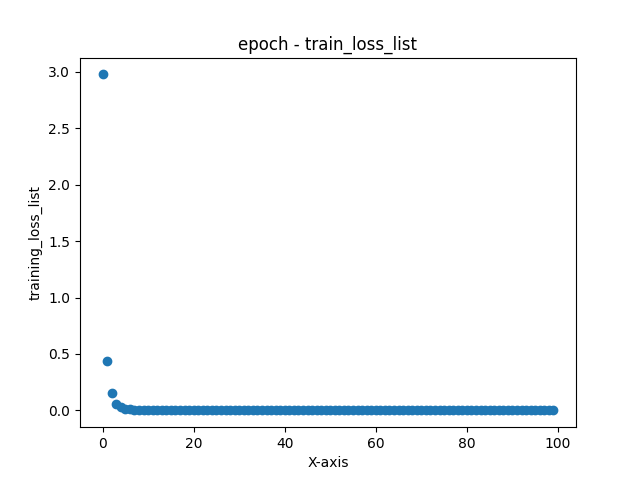
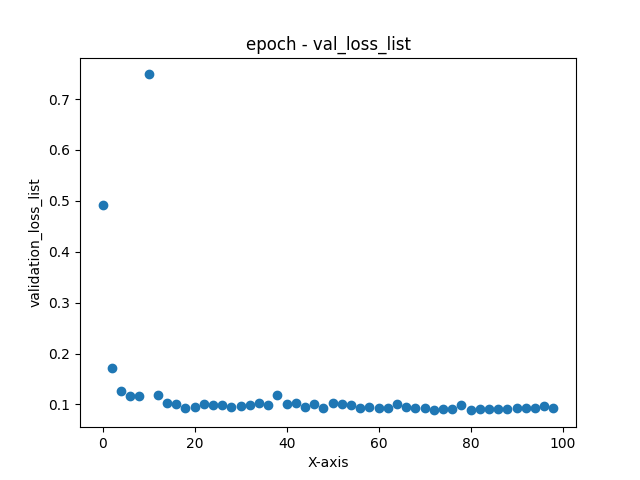
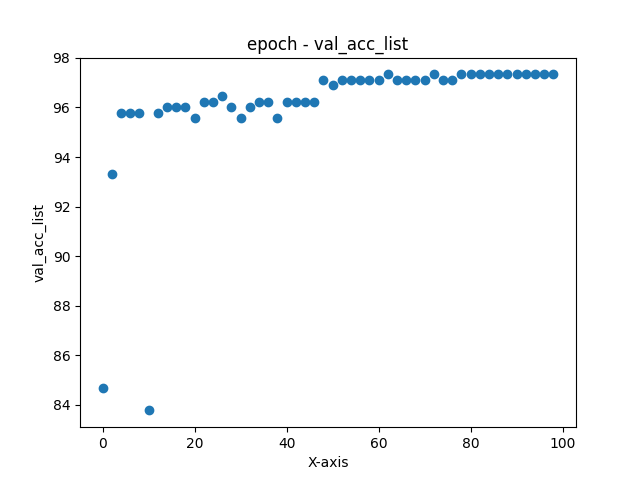


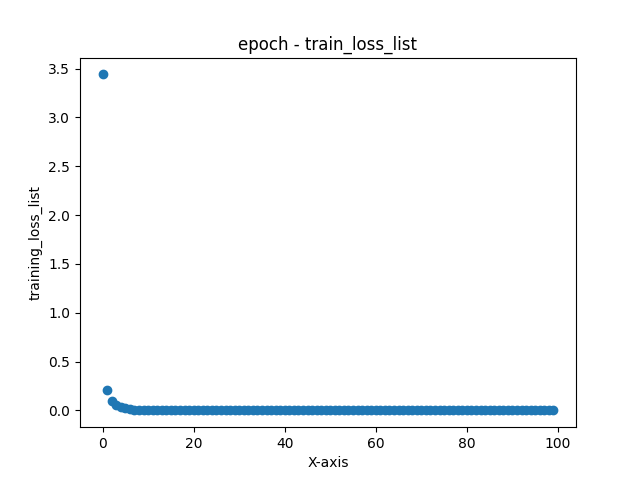
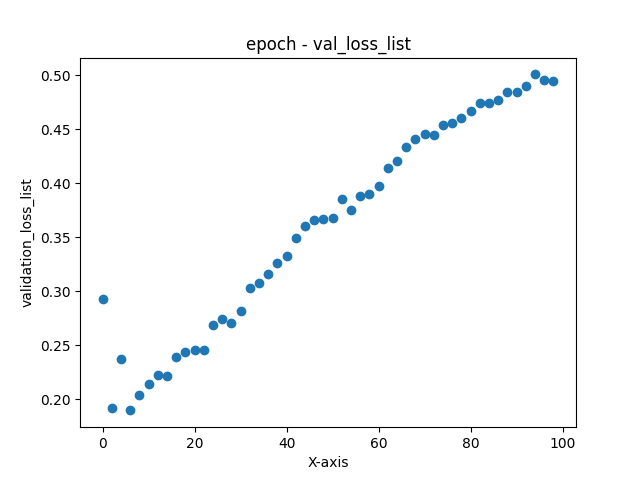
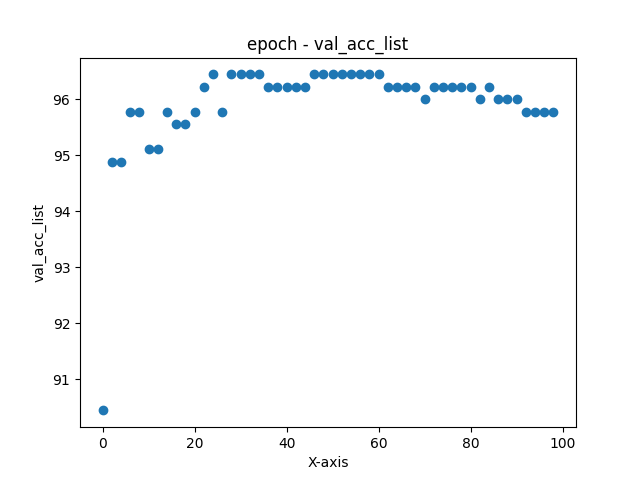


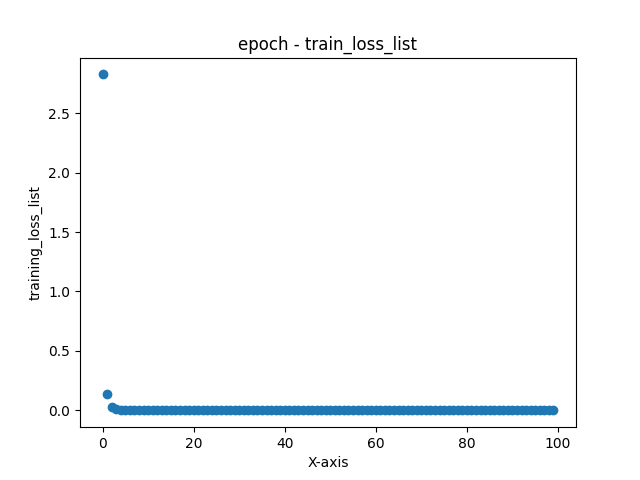
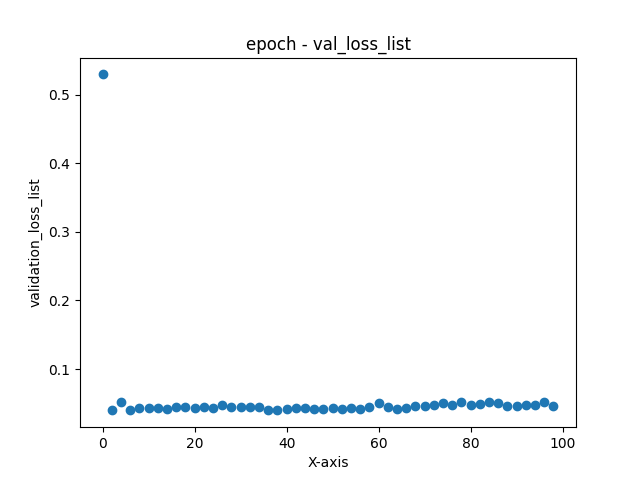
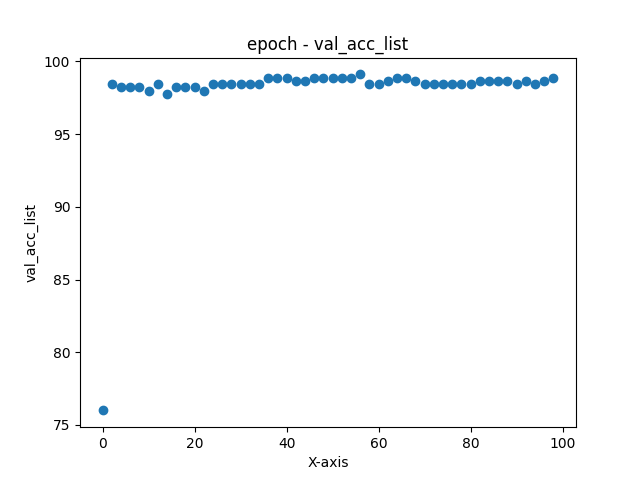


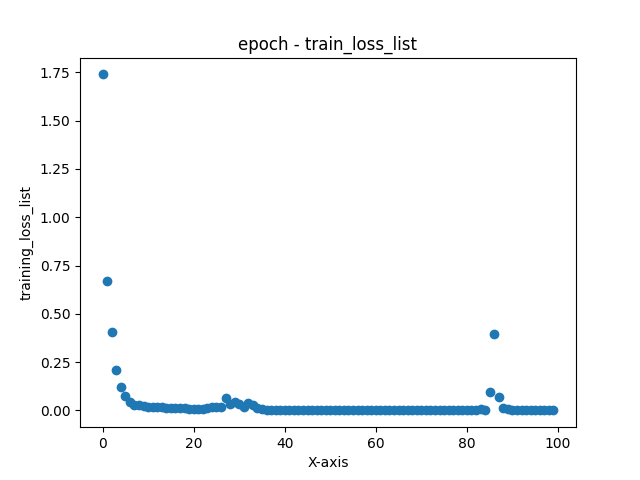
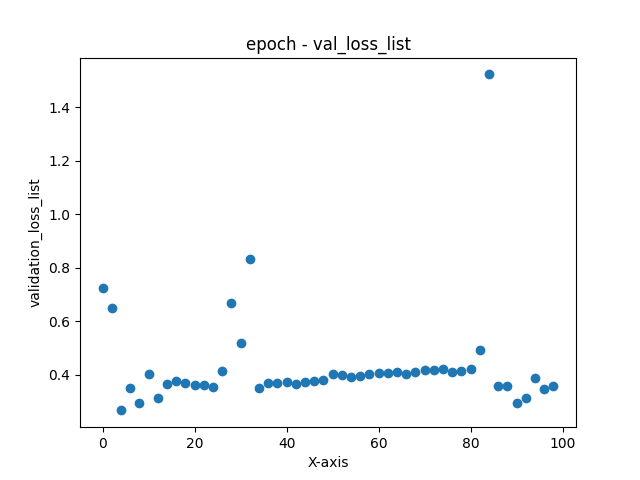
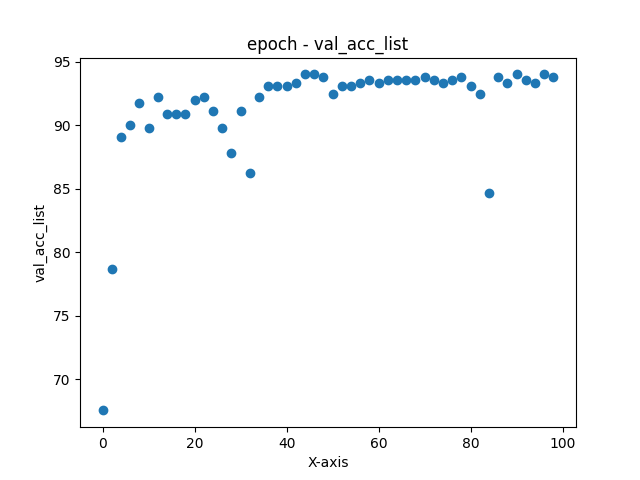

In [ ]:
import pickle
import matplotlib.pyplot as plt
import os
def load_result(file_path):
    with open(file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    return loaded_data


def plot_epoch_result(dataset_name,y_label_name):
    result_dict=load_result('./checkpoints/'+dataset_name+'.pkl')
    if not os.path.exists('./traing_result_pic'):
        os.mkdir('./traing_result_pic')
    if y_label_name=='training_loss_list':
        x_list=result_dict['epoch_list']
        y_list=result_dict['training_loss_list']
        plt.scatter(x_list,y_list)
        plt.title('epoch - train_loss_list')
        plt.xlabel('epoch')
        plt.ylabel(y_label_name)
        plt.savefig('./traing_result_pic/'+dataset_name+'_'+'epoch'+'_'+y_label_name+'.png')
        plt.close()

    elif y_label_name=='val_acc_list':
        x_list=result_dict['epoch_list'][::2]
        y_list=result_dict['val_acc_list']
        plt.scatter(x_list,y_list)
        plt.title('epoch - val_acc_list')
        plt.xlabel('epoch')
        plt.ylabel(y_label_name)
        plt.savefig('./traing_result_pic/'+dataset_name+'_'+'epoch'+'_'+y_label_name+'.png')
        plt.close()
    elif y_label_name=='validation_loss_list':
        x_list=result_dict['epoch_list'][::2]
        y_list=result_dict['validation_loss_list']
        plt.scatter(x_list,y_list)
        plt.title('epoch - val_loss_list')
        plt.xlabel('epoch')
        plt.ylabel(y_label_name)
        plt.savefig('./traing_result_pic/'+dataset_name+'_'+'epoch'+'_'+y_label_name+'.png')
        plt.close()
    pic_path='./traing_result_pic/'+dataset_name+'_'+'epoch'+'_'+y_label_name+'.png'
    return pic_path

data_set_name_list=['color_type_random_dataset','side_legnth_type_random_dataset','rotation_bool_dataset','hard_dataset']
y_label_name_list=['training_loss_list','validation_loss_list','val_acc_list']

for data_set_name in data_set_name_list:
    pic_path_list=[]
    for y_label_name in y_label_name_list:
        pic_path=plot_epoch_result(data_set_name,y_label_name)
        pic_path_list.append(pic_path)
    display_side_by_side(pic_path_list)

In [ ]:
print('visualize_finish!')
print('The result is obvious, it does not matter the change of color while the change of size, roation, which says shape matters')
print('A way to increase stategy is to append more training data.')
print('Second solution is that the mistake case always find in that too small shape.')
print('A desriable way to solve is to emoplye the contour tracing trick and enlarge that contour,')
print('and the case will turn into changed color case simlilarly')
